# Exploring AE, DAE and CAE with MNIST
1. We consider basic/undercomplete AE, denoising AE (DAE) and contractive AE (CAE)
2. For CAE, I need to find out whether there is a more efficient way of computing Jacobian

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Basic AE
1. Learning Rate is a very important Hyperparam: usually 0.01 is good
2. Adam or Adadelta are usually good
3. If normalized, use tf.variance_scaling_initializer() for fast convergence

In [3]:
def basic_ae(n_hidden, input_dim, reg=None, reg_param=None):
    """
        Though named basic, this function is able to create undercomplete AE,
        Sparse AE, and AE with dropout
    """
    initializer = tf.variance_scaling_initializer()
    X_ph = tf.placeholder(tf.float32, shape=(None, input_dim))
    W_1 = tf.Variable(initializer([input_dim, n_hidden]), dtype=tf.float32)
    b_1 = tf.Variable(tf.zeros(n_hidden), dtype=tf.float32)
    z_1 = tf.matmul(X_ph, W_1) + b_1
    a_1 = tf.nn.sigmoid(z_1)
    if reg == 'dropout':
        encoded = tf.nn.dropout(a_1, rate=reg_param) # reg_param = 1 - keep_prob here
    else:
        encoded = a_1
    W_2 = tf.Variable(initializer([n_hidden, input_dim]), dtype=tf.float32)
    b_2 = tf.Variable(tf.zeros(input_dim), dtype=tf.float32)
    z_2 = tf.matmul(encoded, W_2) + b_2
    a_2 = tf.nn.sigmoid(z_2)
    if reg == 'dropout':
        decoded = tf.nn.dropout(a_2, rate=reg_param) # reg_param = 1 - keep_prob here
    else:
        decoded = a_2
    
    if reg == 'l1':
        # divide reg_param by two as we ought to take avg of the two tf.reduce_mean
        reg_factor = tf.constant(reg_param/2)
        loss = tf.reduce_mean(tf.square(decoded-X_ph)) +\
                reg_factor*(tf.reduce_mean(tf.abs(W_1)) + tf.reduce_mean(tf.abs(W_2)))
    else:
        loss = tf.reduce_mean(tf.square(decoded-X_ph))
        
    optimizer = tf.train.AdamOptimizer(0.01)
    train_op = optimizer.minimize(loss)
    
    return X_ph, encoded, decoded, loss, train_op

Instructions for updating:
Colocations handled automatically by placer.
1/50 finished, training loss: 0.053720068708062174
2/50 finished, training loss: 0.03543722008044521
3/50 finished, training loss: 0.03026062767331799
4/50 finished, training loss: 0.027302459608763457
5/50 finished, training loss: 0.024101356950898965
6/50 finished, training loss: 0.021150029692798854
7/50 finished, training loss: 0.018472616213063398
8/50 finished, training loss: 0.01673879588333269
9/50 finished, training loss: 0.015515343953544895
10/50 finished, training loss: 0.014533503943433364
11/50 finished, training loss: 0.013777731138591966
12/50 finished, training loss: 0.013119733979304632
13/50 finished, training loss: 0.01271178658430775
14/50 finished, training loss: 0.012436976069584488
15/50 finished, training loss: 0.012232426932702462
16/50 finished, training loss: 0.012070687798162302
17/50 finished, training loss: 0.01193571940374871
18/50 finished, training loss: 0.011822293136889735
19/50 

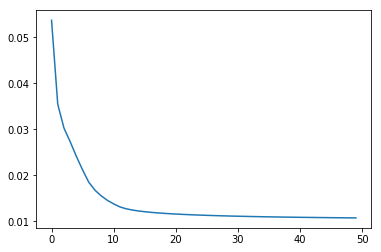

In [4]:
X_ph, encoded, decoded, loss, train_op = basic_ae(32, 784)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
training_loss = []
n_batches = 300 # that will lead to a batch size of 200
batches = np.split(x_train, n_batches)
np.random.shuffle(batches)
n_epoches = 50

for epoch in range(n_epoches):
    batch_loss = 0
    for b in batches:
        _, losses = sess.run([train_op, loss], feed_dict={X_ph: b})
        batch_loss += losses
    training_loss.append(batch_loss/n_batches)
    print(f'{epoch+1}/{n_epoches} finished, training loss: {batch_loss/n_batches}')
plt.plot(training_loss)
plt.show()

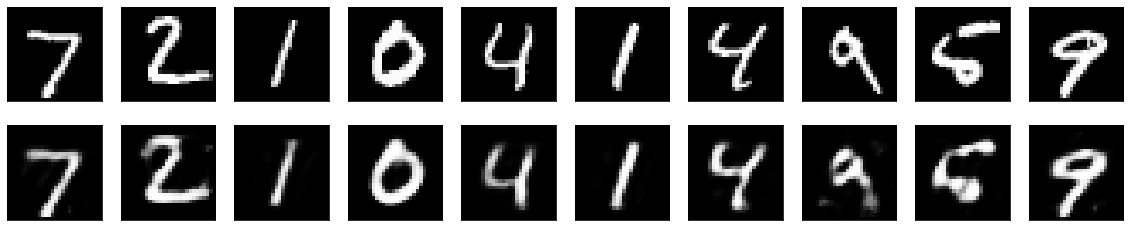

In [5]:
decoded_imgs = sess.run(decoded, feed_dict={X_ph: x_test})
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Adding Sparsity Constraint - L1 Regularization

1/50 finished, training loss: 0.06264102739592393
2/50 finished, training loss: 0.04457427233457565
3/50 finished, training loss: 0.0398962048937877
4/50 finished, training loss: 0.03752498524884383
5/50 finished, training loss: 0.035576563316086926
6/50 finished, training loss: 0.03412301279604435
7/50 finished, training loss: 0.03300035707652569
8/50 finished, training loss: 0.0317908962816
9/50 finished, training loss: 0.030575243160128593
10/50 finished, training loss: 0.02993069761743148
11/50 finished, training loss: 0.029524823104341825
12/50 finished, training loss: 0.02923307867720723
13/50 finished, training loss: 0.02901104828963677
14/50 finished, training loss: 0.028822254240512848
15/50 finished, training loss: 0.0286431481440862
16/50 finished, training loss: 0.028473725815614064
17/50 finished, training loss: 0.02831261243671179
18/50 finished, training loss: 0.028158863751838605
19/50 finished, training loss: 0.028015879485756158
20/50 finished, training loss: 0.027887

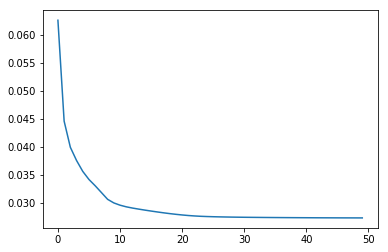

In [6]:
# close the previous tf.Session
sess.close()

X_ph, encoded, decoded, loss, train_op = basic_ae(32, 784, reg='l1', reg_param=0.1)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
n_epoches = 50
training_loss = []
for epoch in range(n_epoches):
    batch_loss = 0
    for b in batches:
        _, losses = sess.run([train_op, loss], feed_dict={X_ph: b})
        batch_loss += losses
    training_loss.append(batch_loss/n_batches)
    print(f'{epoch+1}/{n_epoches} finished, training loss: {batch_loss/n_batches}')
plt.plot(training_loss)
plt.show()

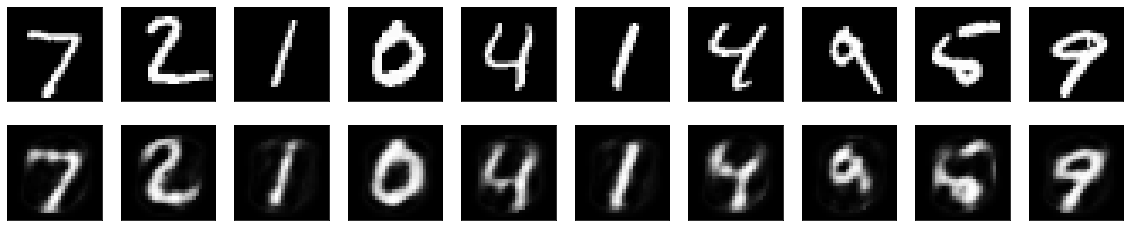

In [7]:
decoded_imgs = sess.run(decoded, feed_dict={X_ph: x_test})
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Dropout Regularization

1/50 finished, training loss: 0.06628751877695321
2/50 finished, training loss: 0.053442166037857536
3/50 finished, training loss: 0.05131280317902565
4/50 finished, training loss: 0.05021729261924823
5/50 finished, training loss: 0.049883715932567914
6/50 finished, training loss: 0.049628591164946556
7/50 finished, training loss: 0.04934629773100217
8/50 finished, training loss: 0.04913922801613808
9/50 finished, training loss: 0.048991314421097436
10/50 finished, training loss: 0.048759042794505755
11/50 finished, training loss: 0.04855327503134807
12/50 finished, training loss: 0.04834589761992296
13/50 finished, training loss: 0.04833477365473906
14/50 finished, training loss: 0.04814692858606577
15/50 finished, training loss: 0.047955829811592895
16/50 finished, training loss: 0.04803002869089445
17/50 finished, training loss: 0.04787742655724287
18/50 finished, training loss: 0.04782368877281745
19/50 finished, training loss: 0.04775043904781342
20/50 finished, training loss: 0.0

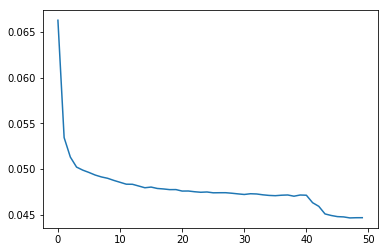

In [8]:
# close the previous tf.Session
sess.close()

X_ph, encoded, decoded, loss, train_op = basic_ae(32, 784, reg='dropout', reg_param=0.1)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
n_epoches = 50
training_loss = []
for epoch in range(n_epoches):
    batch_loss = 0
    for b in batches:
        _, losses = sess.run([train_op, loss], feed_dict={X_ph: b})
        batch_loss += losses
    training_loss.append(batch_loss/n_batches)
    print(f'{epoch+1}/{n_epoches} finished, training loss: {batch_loss/n_batches}')
plt.plot(training_loss)
plt.show()

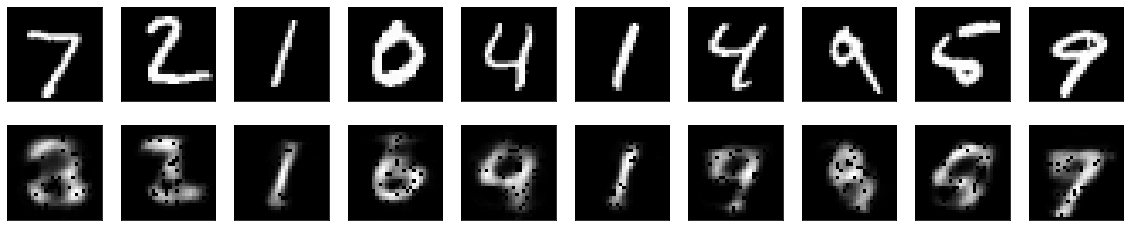

In [9]:
decoded_imgs = sess.run(decoded, feed_dict={X_ph: x_test})
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
sess.close()

## Denoising AE

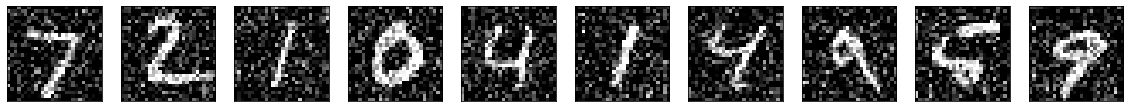

In [10]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
sess.close()
def denoise_ae(n_hidden, input_dim, reg=None, reg_param=0.1):
    initializer = tf.variance_scaling_initializer()
    X_ph = tf.placeholder(tf.float32, shape=(None, input_dim)) # noisy input
    Y_ph = tf.placeholder(tf.float32, shape=(None, input_dim)) # orginal data
    W_1 = tf.Variable(initializer([input_dim, n_hidden]), dtype=tf.float32)
    b_1 = tf.Variable(tf.zeros(n_hidden), dtype=tf.float32)
    z_1 = tf.matmul(X_ph, W_1) + b_1
    a_1 = tf.nn.sigmoid(z_1)
    if reg == 'dropout':
        encoded = tf.nn.dropout(a_1, rate=reg_param) # reg_param = 1 - keep_prob here
    else:
        encoded = a_1
    W_2 = tf.Variable(initializer([n_hidden, input_dim]), dtype=tf.float32)
    b_2 = tf.Variable(tf.zeros(input_dim), dtype=tf.float32)
    z_2 = tf.matmul(encoded, W_2) + b_2
    a_2 = tf.nn.sigmoid(z_2)
    if reg == 'dropout':
        decoded = tf.nn.dropout(a_2, rate=reg_param) # reg_param = 1 - keep_prob here
    else:
        decoded = a_2
    
    
    if reg == 'l1':
        reg_factor = tf.constant(reg_param)
        loss = tf.reduce_mean(tf.square(decoded-Y_ph)) +\
                reg_factor*(tf.reduce_mean(tf.abs(W_1)) + tf.reduce_mean(tf.abs(W_2)))
    else:
        loss = tf.reduce_mean(tf.square(decoded-Y_ph))
    optimizer = tf.train.AdamOptimizer(0.01)
    train_op = optimizer.minimize(loss)
    
    return X_ph, Y_ph, encoded, decoded, loss, train_op

# we enlarge the number of hidden units to 64 as this is more difficult task
X_ph, Y_ph, encoded, decoded, loss, train_op = denoise_ae(64, 784, reg='l1', reg_param=0.1)

1/50 finished, training loss: 0.05987248922387759
2/50 finished, training loss: 0.039899597292145095
3/50 finished, training loss: 0.03494634909555316
4/50 finished, training loss: 0.031732157655060295
5/50 finished, training loss: 0.029295397456735373
6/50 finished, training loss: 0.027439415665964285
7/50 finished, training loss: 0.02605786606669426
8/50 finished, training loss: 0.02516083244855205
9/50 finished, training loss: 0.024630459553251664
10/50 finished, training loss: 0.02430142231285572
11/50 finished, training loss: 0.024081193475673595
12/50 finished, training loss: 0.02392592953518033
13/50 finished, training loss: 0.023810372402270633
14/50 finished, training loss: 0.02372262506435315
15/50 finished, training loss: 0.02365609023720026
16/50 finished, training loss: 0.023604791332036256
17/50 finished, training loss: 0.023563016075640916
18/50 finished, training loss: 0.023526162126411995
19/50 finished, training loss: 0.023490657626340786
20/50 finished, training loss

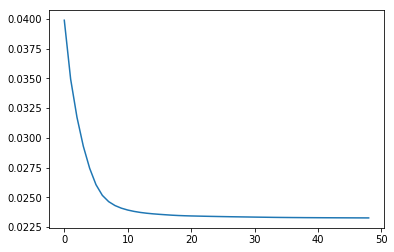

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
training_loss = []

# we need to shuffle two datasets at the same time, so might as well shuffle the indexing
batch_index = np.split(np.arange(x_train.shape[0]), n_batches)
np.random.shuffle(batch_index)
n_epoches = 50

for epoch in range(n_epoches):
    batch_loss = 0
    for idx in batch_index:
        _, losses = sess.run([train_op, loss], feed_dict={X_ph: x_train_noisy[idx],
                                                            Y_ph: x_train[idx]})
        batch_loss += losses
    training_loss.append(batch_loss/n_batches)
    print(f'{epoch+1}/{n_epoches} finished, training loss: {batch_loss/n_batches}')
plt.plot(training_loss[1:])
plt.show()

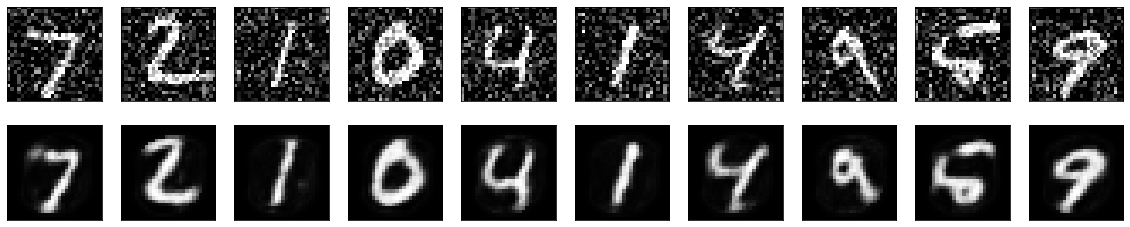

In [13]:
decoded_imgs = sess.run(decoded, feed_dict={X_ph: x_test_noisy})
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
sess.close()

## Contractive AE
> Instead of L-1 or Dropout, CAE uses Frobenius norm of the Jacobian matrix. The purpose is to make the learned representation to be robust towards small changes around the training examples.<br>
The current implementation of calculating the Frobenius norm of the Jacobian in tensorflow is not very efficient, thus the training takes much longer than other form of AEs.

In [14]:
def contractive_ae(n_hidden, input_dim, reg_param=0.1):
    initializer = tf.variance_scaling_initializer()
    X_ph = tf.placeholder(tf.float32, shape=(None, input_dim))
    W_1 = tf.Variable(initializer([input_dim, n_hidden]), dtype=tf.float32)
    b_1 = tf.Variable(tf.zeros(n_hidden), dtype=tf.float32)
    z_1 = tf.matmul(X_ph, W_1) + b_1
    encoded = tf.nn.sigmoid(z_1)
    W_2 = tf.Variable(initializer([n_hidden, input_dim]), dtype=tf.float32)
    b_2 = tf.Variable(tf.zeros(input_dim), dtype=tf.float32)
    z_2 = tf.matmul(encoded, W_2) + b_2
    decoded = tf.nn.sigmoid(z_2)
    
    # Frobenius norm of the Jacobian
    contractive_loss = tf.reduce_sum(tf.square([tf.gradients(encoded[i], X_ph
                                              ) for i in range(n_hidden)]))

    loss = tf.reduce_mean(tf.square(decoded-X_ph)) + \
            tf.constant(reg_param)*contractive_loss
    optimizer = tf.train.AdamOptimizer(0.01)
    train_op = optimizer.minimize(loss)
    
    return X_ph, encoded, decoded, loss, train_op

Instructions for updating:
Use tf.cast instead.
1/50 finished, training loss: 0.1573778299614787
2/50 finished, training loss: 0.06731666043400765
3/50 finished, training loss: 0.06678697798401118
4/50 finished, training loss: 0.06598704235007366
5/50 finished, training loss: 0.06416698717822632
6/50 finished, training loss: 0.06080275213966767
7/50 finished, training loss: 0.05744782062868277
8/50 finished, training loss: 0.05377724268784126
9/50 finished, training loss: 0.05054970702777306
10/50 finished, training loss: 0.04494619999080896
11/50 finished, training loss: 0.04487646515170733
12/50 finished, training loss: 0.04330905565371116
13/50 finished, training loss: 0.042283850125968456
14/50 finished, training loss: 0.03930173558493455
15/50 finished, training loss: 0.039788510613143445
16/50 finished, training loss: 0.03864819242308537
17/50 finished, training loss: 0.03870044524470965
18/50 finished, training loss: 0.03899470369021098
19/50 finished, training loss: 0.038902685

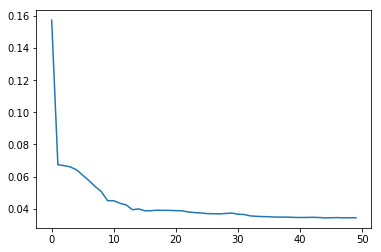

In [15]:
# close the previous session
sess.close()

X_ph, encoded, decoded, loss, train_op = contractive_ae(32, 784)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
training_loss = []
n_batches = 300 # that will lead to a batch size of 200
batches = np.split(x_train, n_batches)
np.random.shuffle(batches)
n_epoches = 50

for epoch in range(n_epoches):
    batch_loss = 0
    for b in batches:
        _, losses = sess.run([train_op, loss], feed_dict={X_ph: b})
        batch_loss += losses
    training_loss.append(batch_loss/n_batches)
    print(f'{epoch+1}/{n_epoches} finished, training loss: {batch_loss/n_batches}')
plt.plot(training_loss)
plt.show()

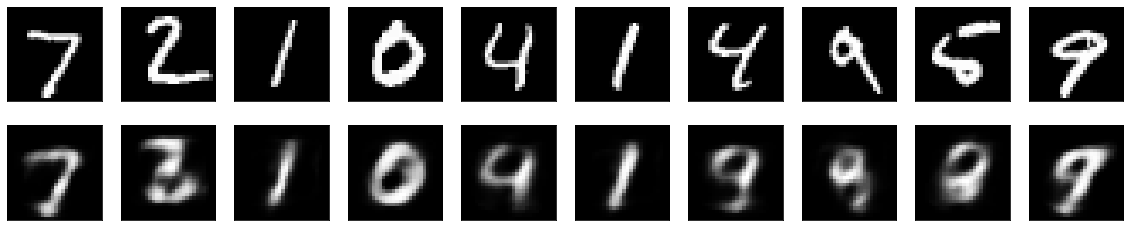

In [16]:
decoded_imgs = sess.run(decoded, feed_dict={X_ph: x_test})
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()